In [1]:
import pandas as pd
import math
import random
import numpy as np
import copy
import xlsxwriter
import matplotlib.pyplot as plt
import time
class Sol():
    def __init__(self):
        self.nodes_seq=None
        self.obj=None
        self.routes=None
        self.distance = None
        self.num_vehicle = None
        self.over_due = None
class Node():
    def __init__(self):
        self.id=0
        self.name=''
        self.seq_no=0
        self.x_coord=0
        self.y_coord=0
        self.demand=0
        self.left_time_window = 0
        self.right_time_window = 0
        self.service_time = 0
        self.distance_to_depot = 0
class Model():
    '''
    Model()类，存储算法参数
    params:
    best_sol:全局最优解，值类型为Sol()
    node_list:物理节点集合，值类型为Node()
    node_seq_no_list:物理节点映射id集合
    depot:车辆基地，值类型为Node()
    number_of_nodes:需求节点数量
    tabu_list:禁忌表
    TL:算子禁忌长度
    opt_type:优化目标类型，0：最小车辆数，1：最小行驶距离
    vehicle_cap:车辆容量
    '''
    def __init__(self):
        self.best_sol=None
        self.node_list=[]
        self.node_seq_no_list=[]
        self.depot=None
        self.number_of_nodes=0
        self.tabu_list=None
        self.TL=30
        self.opt_type=0
        self.vehicle_cap=0
        self.distance = None
        self.speed = 10

def readXlsxFile(filepath,model):
    df = pd.read_excel(filepath)
    node_seq_no = -1
    for i in range(df.shape[0]):
        # 每次循环生成一个node类对象
        node=Node()
        # 从-1开始赋予id，仓库id为-1
        node.id=node_seq_no
        node.seq_no=node_seq_no
        node.x_coord= df['x_coord'][i]
        node.y_coord= df['y_coord'][i]
        node.demand=df['demand'][i]
        node.left_time_window = df['left_time_window'][i]
        node.right_time_window = df['right_time_window'][i]
        node.service_time = df['service_time'][i]
        if df['demand'][i] == 0:
            model.depot=node
        else:
            model.node_list.append(node)
            # 储存映射id，与excel表中的id不一致
            model.node_seq_no_list.append(node_seq_no)
        try:
            node.name=df['name'][i]
        except:
            pass
        # 如果有id号，尝试添加id
        try:
            node.id=df['id'][i]
        except:
            pass
        node_seq_no=node_seq_no+1
    model.number_of_nodes=len(model.node_list)

def initParam(model,distance_type = 0,distance_matrix = None,distance_to_depot = None):
    # 初始化距离邻接矩阵
    model.distance = np.zeros((model.number_of_nodes,model.number_of_nodes))
    if distance_type == 0:
        for i in range(model.number_of_nodes):
            model.node_list[i].distance_to_depot = np.sqrt((model.node_list[i].x_coord-model.depot.x_coord)**2+\
                            (model.node_list[i].y_coord-model.depot.y_coord)**2) 
            for j in range(i+1,model.number_of_nodes):
                d=np.sqrt((model.node_list[i].x_coord-model.node_list[j].x_coord)**2+\
                            (model.node_list[i].y_coord-model.node_list[j].y_coord)**2)
                model.distance[i,j]=d
                model.distance[j,i]=d
    elif distance_type == 1:
        for i in range(model.number_of_nodes):
            model.node_list[i].distance_to_depot = np.abs(model.node_list[i].x_coord-model.depot.x_coord)+\
                            np.abs(model.node_list[i].y_coord-model.depot.y_coord)
            for j in range(i+1,model.number_of_nodes):
                d=np.abs(model.node_list[i].x_coord-model.node_list[j].x_coord)+\
                            np.abs(model.node_list[i].y_coord-model.node_list[j].y_coord)
                model.distance[i,j]=d
                model.distance[j,i]=d
    elif distance_type == 3:
        for i in range(model.number_of_nodes):
            model.node_list[i].distance_to_depot = distance_to_depot[i]
        model.distance = distance_matrix
    
def splitRoutes(nodes_seq,model):
    num_vehicle = 0
    vehicle_routes = []
    route = []
    remained_cap = model.vehicle_cap
    # 计算仓库到该路线第一个配送点时间
    time_counter = 0
    over_due = 0
    
    for i in range(len(nodes_seq)):
        ### 第一层条件语句判断是否满足容量约束
        if remained_cap - model.node_list[nodes_seq[i]].demand >= 0:
            ## 第二层第一个条件语句判断路径是否为空，不为空则路径中已存在配送点
            if len(route)== 0:
                time_counter = model.node_list[nodes_seq[i]].distance_to_depot/model.speed
            else:
                time_counter+= model.distance[range(model.number_of_nodes).index(route[-1]),\
                                             range(model.number_of_nodes).index(nodes_seq[i])]/model.speed
            ## 第二层第二个条件语句计算到达时间与时间窗    
            if time_counter < model.node_list[nodes_seq[i]].left_time_window:
                #小于左时间窗，计时器从左时间窗起加服务时间
                time_counter = model.node_list[nodes_seq[i]].left_time_window + model.node_list[nodes_seq[i]].service_time
                route.append(nodes_seq[i])
                remained_cap = remained_cap - model.node_list[nodes_seq[i]].demand
            elif (time_counter >= model.node_list[nodes_seq[i]].left_time_window)&\
                                            (time_counter<=model.node_list[nodes_seq[i]].right_time_window):
                #大于左时间窗小于右时间窗，计时器自增服务时间
                time_counter += model.node_list[nodes_seq[i]].service_time
                route.append(nodes_seq[i])
                remained_cap = remained_cap - model.node_list[nodes_seq[i]].demand
            else:
                #超出时间窗
                if len(route)==0:
                    route.append(nodes_seq[i])
                    vehicle_routes.append(route)
                    over_due+=1
                    route = []
                else:
                    vehicle_routes.append(route)
                    route = [nodes_seq[i]]
                    time_counter = model.node_list[nodes_seq[i]].distance_to_depot
                    remained_cap = model.vehicle_cap - model.node_list[nodes_seq[i]].demand
                
        else:
            vehicle_routes.append(route)
            route = [nodes_seq[i]]
            time_counter = model.node_list[nodes_seq[i]].distance_to_depot/model.speed
            remained_cap = model.vehicle_cap - model.node_list[nodes_seq[i]].demand
            
    if len(route)>0:
        vehicle_routes.append(route)
    num_vehicle = len(vehicle_routes)
    return num_vehicle,vehicle_routes,over_due

In [2]:

def calDistance(route,model):
    distance=0
    depot=model.depot
    for i in range(len(route)-1):
        from_node=model.node_list[route[i]]
        to_node=model.node_list[route[i+1]]
        distance+=math.sqrt((from_node.x_coord-to_node.x_coord)**2+(from_node.y_coord-to_node.y_coord)**2)
    first_node=model.node_list[route[0]]
    last_node=model.node_list[route[-1]]
    distance+=math.sqrt((depot.x_coord-first_node.x_coord)**2+(depot.y_coord-first_node.y_coord)**2)
    distance+=math.sqrt((depot.x_coord-last_node.x_coord)**2+(depot.y_coord - last_node.y_coord)**2)
    return distance
def calObj(nodes_seq,model):
    # calculate obj value
    num_vehicle, vehicle_routes,over_due = splitRoutes(nodes_seq, model)
    if model.opt_type==0:
        return num_vehicle,vehicle_routes,over_due
    else:
        distance=0
        for route in vehicle_routes:
            distance+=calDistance(route,model)
        return distance,vehicle_routes,over_due
def plotObj(obj_list):
    plt.rcParams['font.sans-serif'] = ['SimHei']  #show chinese
    plt.rcParams['axes.unicode_minus'] = False  # Show minus sign
    plt.plot(np.arange(1,len(obj_list)+1),obj_list)
    plt.xlabel('Iterations')
    plt.ylabel('Obj Value')
    plt.grid()
    plt.xlim(1,len(obj_list)+1)
    plt.show()
def outPut(model):
    work = xlsxwriter.Workbook('result.xlsx')
    worksheet = work.add_worksheet()
    worksheet.write(0, 0, 'opt_type')
    worksheet.write(1, 0, 'obj')
    if model.opt_type == 0:
        worksheet.write(0, 1, 'number of vehicles')
    else:
        worksheet.write(0, 1, 'drive distance of vehicles')
    worksheet.write(1, 1, model.best_sol.obj)
    for row, route in enumerate(model.best_sol.routes):
        worksheet.write(row + 2, 0, 'v' + str(row + 1))
        r = [str(i) for i in route]
        worksheet.write(row + 2, 1, '-'.join(r))
    work.close()


In [3]:
def genInitialSol(node_seq):
    '''
    随机生成一个初始解（随机访问路径序列）
    '''
    node_seq=copy.deepcopy(node_seq)
    random.seed(0)
    random.shuffle(node_seq)
    return node_seq
def createActions(n):
    '''
    生成邻域算子
    算子1：单节点交换，即将nodes_seq序列前半部分与后半部分对应位置的需求节点交换；
    算子2：双节点交换，即将nodes_seq序列前半部分紧邻两个位置的需求节点与对应的后半部分紧邻位置的需求节点交换；
    算子3：指定长度的片段反序；
    '''
    action_list=[]
    nswap=n//2
    #Single point exchange
    for i in range(nswap):
        action_list.append([1,i,i+nswap])
    #Two point exchange
    for i in range(0,nswap,2):
        action_list.append([2,i,i+nswap])
    #Reverse sequence
    for i in range(0,n,4):
        action_list.append([3,i,i+3])
    return action_list

In [4]:
def doACtion(nodes_seq,action):
    nodes_seq=copy.deepcopy(nodes_seq)
    if action[0]==1:
        index_1=action[1]
        index_2=action[2]
        temporary=nodes_seq[index_1]
        nodes_seq[index_1]=nodes_seq[index_2]
        nodes_seq[index_2]=temporary
        return nodes_seq
    elif action[0]==2:
        index_1 = action[1]
        index_2 = action[2]
        temporary=[nodes_seq[index_1],nodes_seq[index_1+1]]
        nodes_seq[index_1]=nodes_seq[index_2]
        nodes_seq[index_1+1]=nodes_seq[index_2+1]
        nodes_seq[index_2]=temporary[0]
        nodes_seq[index_2+1]=temporary[1]
        return nodes_seq
    elif action[0]==3:
        index_1=action[1]
        index_2=action[2]
        nodes_seq[index_1:index_2+1]=list(reversed(nodes_seq[index_1:index_2+1]))
        return nodes_seq

In [5]:
def run(filepath,epochs,v_cap,opt_type):
    """
    :param filepath: :Xlsx file path
    :param epochs: Iterations
    :param v_cap: Vehicle capacity
    :param opt_type:Optimization type:0:Minimize the number of vehicles,1:Minimize travel distance
    :return: 无
    """
    model=Model()
    model.vehicle_cap=v_cap
    model.opt_type=opt_type
    readXlsxFile(filepath,model)
    initParam(model)
    # 生成邻域算子
    action_list=createActions(model.number_of_nodes)
    # 生成禁忌表，长度等于算子表长度
    model.tabu_list=np.zeros(len(action_list))
    history_best_obj=[]
    sol=Sol()
    sol.nodes_seq=genInitialSol(model.node_seq_no_list)
    sol.obj,sol.routes,sol.over_due=calObj(sol.nodes_seq,model)
    model.best_sol=copy.deepcopy(sol)
    history_best_obj.append(sol.obj)
    # 开始迭代
    for ep in range(epochs):
        # 设置初代最优解
        local_new_sol=Sol()
        local_new_sol.obj=float('inf')
        for i in range(len(action_list)):
            # 生成邻域解集
            if model.tabu_list[i]==0:
                new_sol=Sol()
                # 执行对应的邻域算子策略
                new_sol.nodes_seq=doACtion(sol.nodes_seq,action_list[i])
                new_sol.obj,new_sol.routes,new_sol.over_due=calObj(new_sol.nodes_seq,model)
                new_sol.action_id=i
                if new_sol.obj<local_new_sol.obj:
                    local_new_sol=copy.deepcopy(new_sol)
        sol=local_new_sol
        for i in range(len(action_list)):
            if i==sol.action_id:
                model.tabu_list[sol.action_id]=model.TL
            else:
                model.tabu_list[i]=max(model.tabu_list[i]-1,0)
        if sol.obj<model.best_sol.obj:
            model.best_sol=copy.deepcopy(sol)
        history_best_obj.append(model.best_sol.obj)
        print("%s/%s: best obj: %s num_vehicle: %s"%(ep,epochs,model.best_sol.obj,len(model.best_sol.routes)))
    plotObj(history_best_obj)
    outPut(model)

0/3000: best obj: 4765.978952533137 num_vehicle: 39
1/3000: best obj: 4688.028069984515 num_vehicle: 39
2/3000: best obj: 4614.67178299143 num_vehicle: 39
3/3000: best obj: 4545.1674996356405 num_vehicle: 39
4/3000: best obj: 4477.132249781482 num_vehicle: 39
5/3000: best obj: 4411.04217522942 num_vehicle: 39
6/3000: best obj: 4351.203467504029 num_vehicle: 39
7/3000: best obj: 4299.7968036900775 num_vehicle: 39
8/3000: best obj: 4252.37076226989 num_vehicle: 38
9/3000: best obj: 4207.331807432985 num_vehicle: 38
10/3000: best obj: 4163.455950578452 num_vehicle: 37
11/3000: best obj: 4132.386684499107 num_vehicle: 37
12/3000: best obj: 4105.111268039455 num_vehicle: 37
13/3000: best obj: 4078.4961634108677 num_vehicle: 38
14/3000: best obj: 4054.8368835721317 num_vehicle: 37
15/3000: best obj: 4033.962055617332 num_vehicle: 36
16/3000: best obj: 4015.0146938048833 num_vehicle: 35
17/3000: best obj: 3937.2098748194867 num_vehicle: 35
18/3000: best obj: 3919.679479647235 num_vehicle: 35


156/3000: best obj: 3651.6104101065953 num_vehicle: 34
157/3000: best obj: 3651.6104101065953 num_vehicle: 34
158/3000: best obj: 3651.6104101065953 num_vehicle: 34
159/3000: best obj: 3651.6104101065953 num_vehicle: 34
160/3000: best obj: 3651.6104101065953 num_vehicle: 34
161/3000: best obj: 3651.6104101065953 num_vehicle: 34
162/3000: best obj: 3651.6104101065953 num_vehicle: 34
163/3000: best obj: 3651.6104101065953 num_vehicle: 34
164/3000: best obj: 3651.6104101065953 num_vehicle: 34
165/3000: best obj: 3651.6104101065953 num_vehicle: 34
166/3000: best obj: 3651.6104101065953 num_vehicle: 34
167/3000: best obj: 3651.6104101065953 num_vehicle: 34
168/3000: best obj: 3651.6104101065953 num_vehicle: 34
169/3000: best obj: 3651.6104101065953 num_vehicle: 34
170/3000: best obj: 3651.6104101065953 num_vehicle: 34
171/3000: best obj: 3651.6104101065953 num_vehicle: 34
172/3000: best obj: 3651.6104101065953 num_vehicle: 34
173/3000: best obj: 3651.6104101065953 num_vehicle: 34
174/3000: 

310/3000: best obj: 3347.80857679993 num_vehicle: 35
311/3000: best obj: 3347.80857679993 num_vehicle: 35
312/3000: best obj: 3347.80857679993 num_vehicle: 35
313/3000: best obj: 3347.80857679993 num_vehicle: 35
314/3000: best obj: 3347.80857679993 num_vehicle: 35
315/3000: best obj: 3347.80857679993 num_vehicle: 35
316/3000: best obj: 3347.80857679993 num_vehicle: 35
317/3000: best obj: 3347.80857679993 num_vehicle: 35
318/3000: best obj: 3347.80857679993 num_vehicle: 35
319/3000: best obj: 3347.80857679993 num_vehicle: 35
320/3000: best obj: 3347.80857679993 num_vehicle: 35
321/3000: best obj: 3347.80857679993 num_vehicle: 35
322/3000: best obj: 3347.80857679993 num_vehicle: 35
323/3000: best obj: 3347.80857679993 num_vehicle: 35
324/3000: best obj: 3347.80857679993 num_vehicle: 35
325/3000: best obj: 3347.80857679993 num_vehicle: 35
326/3000: best obj: 3347.80857679993 num_vehicle: 35
327/3000: best obj: 3342.10838992808 num_vehicle: 34
328/3000: best obj: 3342.10838992808 num_vehic

466/3000: best obj: 3317.430317982543 num_vehicle: 37
467/3000: best obj: 3317.430317982543 num_vehicle: 37
468/3000: best obj: 3317.430317982543 num_vehicle: 37
469/3000: best obj: 3317.430317982543 num_vehicle: 37
470/3000: best obj: 3317.430317982543 num_vehicle: 37
471/3000: best obj: 3317.430317982543 num_vehicle: 37
472/3000: best obj: 3317.430317982543 num_vehicle: 37
473/3000: best obj: 3317.430317982543 num_vehicle: 37
474/3000: best obj: 3317.430317982543 num_vehicle: 37
475/3000: best obj: 3317.430317982543 num_vehicle: 37
476/3000: best obj: 3317.430317982543 num_vehicle: 37
477/3000: best obj: 3317.430317982543 num_vehicle: 37
478/3000: best obj: 3317.430317982543 num_vehicle: 37
479/3000: best obj: 3317.430317982543 num_vehicle: 37
480/3000: best obj: 3317.430317982543 num_vehicle: 37
481/3000: best obj: 3317.430317982543 num_vehicle: 37
482/3000: best obj: 3317.430317982543 num_vehicle: 37
483/3000: best obj: 3317.430317982543 num_vehicle: 37
484/3000: best obj: 3317.430

618/3000: best obj: 3316.8128130957475 num_vehicle: 35
619/3000: best obj: 3316.8128130957475 num_vehicle: 35
620/3000: best obj: 3316.8128130957475 num_vehicle: 35
621/3000: best obj: 3316.8128130957475 num_vehicle: 35
622/3000: best obj: 3316.8128130957475 num_vehicle: 35
623/3000: best obj: 3316.8128130957475 num_vehicle: 35
624/3000: best obj: 3316.8128130957475 num_vehicle: 35
625/3000: best obj: 3316.8128130957475 num_vehicle: 35
626/3000: best obj: 3316.8128130957475 num_vehicle: 35
627/3000: best obj: 3316.8128130957475 num_vehicle: 35
628/3000: best obj: 3316.8128130957475 num_vehicle: 35
629/3000: best obj: 3316.8128130957475 num_vehicle: 35
630/3000: best obj: 3316.8128130957475 num_vehicle: 35
631/3000: best obj: 3316.8128130957475 num_vehicle: 35
632/3000: best obj: 3316.8128130957475 num_vehicle: 35
633/3000: best obj: 3316.8128130957475 num_vehicle: 35
634/3000: best obj: 3316.8128130957475 num_vehicle: 35
635/3000: best obj: 3316.8128130957475 num_vehicle: 35
636/3000: 

772/3000: best obj: 3258.216506880034 num_vehicle: 34
773/3000: best obj: 3258.216506880034 num_vehicle: 34
774/3000: best obj: 3258.216506880034 num_vehicle: 34
775/3000: best obj: 3258.216506880034 num_vehicle: 34
776/3000: best obj: 3258.216506880034 num_vehicle: 34
777/3000: best obj: 3258.216506880034 num_vehicle: 34
778/3000: best obj: 3258.216506880034 num_vehicle: 34
779/3000: best obj: 3258.216506880034 num_vehicle: 34
780/3000: best obj: 3258.216506880034 num_vehicle: 34
781/3000: best obj: 3258.216506880034 num_vehicle: 34
782/3000: best obj: 3258.216506880034 num_vehicle: 34
783/3000: best obj: 3258.216506880034 num_vehicle: 34
784/3000: best obj: 3258.216506880034 num_vehicle: 34
785/3000: best obj: 3258.216506880034 num_vehicle: 34
786/3000: best obj: 3258.216506880034 num_vehicle: 34
787/3000: best obj: 3251.7575624742794 num_vehicle: 34
788/3000: best obj: 3251.7575624742794 num_vehicle: 34
789/3000: best obj: 3251.7575624742794 num_vehicle: 34
790/3000: best obj: 3251.

924/3000: best obj: 3070.1188274396686 num_vehicle: 35
925/3000: best obj: 3070.1188274396686 num_vehicle: 35
926/3000: best obj: 3070.1188274396686 num_vehicle: 35
927/3000: best obj: 3070.1188274396686 num_vehicle: 35
928/3000: best obj: 3070.1188274396686 num_vehicle: 35
929/3000: best obj: 3070.1188274396686 num_vehicle: 35
930/3000: best obj: 3070.1188274396686 num_vehicle: 35
931/3000: best obj: 3070.1188274396686 num_vehicle: 35
932/3000: best obj: 3070.1188274396686 num_vehicle: 35
933/3000: best obj: 3070.1188274396686 num_vehicle: 35
934/3000: best obj: 3070.1188274396686 num_vehicle: 35
935/3000: best obj: 3070.1188274396686 num_vehicle: 35
936/3000: best obj: 3070.1188274396686 num_vehicle: 35
937/3000: best obj: 3070.1188274396686 num_vehicle: 35
938/3000: best obj: 3070.1188274396686 num_vehicle: 35
939/3000: best obj: 3070.1188274396686 num_vehicle: 35
940/3000: best obj: 3070.1188274396686 num_vehicle: 35
941/3000: best obj: 3070.1188274396686 num_vehicle: 35
942/3000: 

1073/3000: best obj: 2956.4132811921877 num_vehicle: 33
1074/3000: best obj: 2956.4132811921877 num_vehicle: 33
1075/3000: best obj: 2956.4132811921877 num_vehicle: 33
1076/3000: best obj: 2956.4132811921877 num_vehicle: 33
1077/3000: best obj: 2956.4132811921877 num_vehicle: 33
1078/3000: best obj: 2956.4132811921877 num_vehicle: 33
1079/3000: best obj: 2956.4132811921877 num_vehicle: 33
1080/3000: best obj: 2956.4132811921877 num_vehicle: 33
1081/3000: best obj: 2956.4132811921877 num_vehicle: 33
1082/3000: best obj: 2956.4132811921877 num_vehicle: 33
1083/3000: best obj: 2956.4132811921877 num_vehicle: 33
1084/3000: best obj: 2956.4132811921877 num_vehicle: 33
1085/3000: best obj: 2956.4132811921877 num_vehicle: 33
1086/3000: best obj: 2956.4132811921877 num_vehicle: 33
1087/3000: best obj: 2956.4132811921877 num_vehicle: 33
1088/3000: best obj: 2956.4132811921877 num_vehicle: 33
1089/3000: best obj: 2956.4132811921877 num_vehicle: 33
1090/3000: best obj: 2956.4132811921877 num_vehi

1225/3000: best obj: 2956.4132811921877 num_vehicle: 33
1226/3000: best obj: 2956.4132811921877 num_vehicle: 33
1227/3000: best obj: 2956.4132811921877 num_vehicle: 33
1228/3000: best obj: 2956.4132811921877 num_vehicle: 33
1229/3000: best obj: 2956.4132811921877 num_vehicle: 33
1230/3000: best obj: 2956.4132811921877 num_vehicle: 33
1231/3000: best obj: 2956.4132811921877 num_vehicle: 33
1232/3000: best obj: 2956.4132811921877 num_vehicle: 33
1233/3000: best obj: 2956.4132811921877 num_vehicle: 33
1234/3000: best obj: 2956.4132811921877 num_vehicle: 33
1235/3000: best obj: 2956.4132811921877 num_vehicle: 33
1236/3000: best obj: 2956.4132811921877 num_vehicle: 33
1237/3000: best obj: 2956.4132811921877 num_vehicle: 33
1238/3000: best obj: 2956.4132811921877 num_vehicle: 33
1239/3000: best obj: 2956.4132811921877 num_vehicle: 33
1240/3000: best obj: 2956.4132811921877 num_vehicle: 33
1241/3000: best obj: 2956.4132811921877 num_vehicle: 33
1242/3000: best obj: 2956.4132811921877 num_vehi

1376/3000: best obj: 2956.4132811921877 num_vehicle: 33
1377/3000: best obj: 2956.4132811921877 num_vehicle: 33
1378/3000: best obj: 2956.4132811921877 num_vehicle: 33
1379/3000: best obj: 2956.4132811921877 num_vehicle: 33
1380/3000: best obj: 2956.4132811921877 num_vehicle: 33
1381/3000: best obj: 2956.4132811921877 num_vehicle: 33
1382/3000: best obj: 2956.4132811921877 num_vehicle: 33
1383/3000: best obj: 2956.4132811921877 num_vehicle: 33
1384/3000: best obj: 2956.4132811921877 num_vehicle: 33
1385/3000: best obj: 2956.4132811921877 num_vehicle: 33
1386/3000: best obj: 2956.4132811921877 num_vehicle: 33
1387/3000: best obj: 2956.4132811921877 num_vehicle: 33
1388/3000: best obj: 2956.4132811921877 num_vehicle: 33
1389/3000: best obj: 2956.4132811921877 num_vehicle: 33
1390/3000: best obj: 2956.4132811921877 num_vehicle: 33
1391/3000: best obj: 2956.4132811921877 num_vehicle: 33
1392/3000: best obj: 2956.4132811921877 num_vehicle: 33
1393/3000: best obj: 2956.4132811921877 num_vehi

1527/3000: best obj: 2956.4132811921877 num_vehicle: 33
1528/3000: best obj: 2956.4132811921877 num_vehicle: 33
1529/3000: best obj: 2956.4132811921877 num_vehicle: 33
1530/3000: best obj: 2956.4132811921877 num_vehicle: 33
1531/3000: best obj: 2956.4132811921877 num_vehicle: 33
1532/3000: best obj: 2956.4132811921877 num_vehicle: 33
1533/3000: best obj: 2956.4132811921877 num_vehicle: 33
1534/3000: best obj: 2956.4132811921877 num_vehicle: 33
1535/3000: best obj: 2956.4132811921877 num_vehicle: 33
1536/3000: best obj: 2956.4132811921877 num_vehicle: 33
1537/3000: best obj: 2956.4132811921877 num_vehicle: 33
1538/3000: best obj: 2956.4132811921877 num_vehicle: 33
1539/3000: best obj: 2956.4132811921877 num_vehicle: 33
1540/3000: best obj: 2956.4132811921877 num_vehicle: 33
1541/3000: best obj: 2956.4132811921877 num_vehicle: 33
1542/3000: best obj: 2956.4132811921877 num_vehicle: 33
1543/3000: best obj: 2956.4132811921877 num_vehicle: 33
1544/3000: best obj: 2956.4132811921877 num_vehi

1675/3000: best obj: 2956.4132811921877 num_vehicle: 33
1676/3000: best obj: 2956.4132811921877 num_vehicle: 33
1677/3000: best obj: 2956.4132811921877 num_vehicle: 33
1678/3000: best obj: 2956.4132811921877 num_vehicle: 33
1679/3000: best obj: 2956.4132811921877 num_vehicle: 33
1680/3000: best obj: 2956.4132811921877 num_vehicle: 33
1681/3000: best obj: 2956.4132811921877 num_vehicle: 33
1682/3000: best obj: 2956.4132811921877 num_vehicle: 33
1683/3000: best obj: 2956.4132811921877 num_vehicle: 33
1684/3000: best obj: 2956.4132811921877 num_vehicle: 33
1685/3000: best obj: 2956.4132811921877 num_vehicle: 33
1686/3000: best obj: 2956.4132811921877 num_vehicle: 33
1687/3000: best obj: 2956.4132811921877 num_vehicle: 33
1688/3000: best obj: 2956.4132811921877 num_vehicle: 33
1689/3000: best obj: 2956.4132811921877 num_vehicle: 33
1690/3000: best obj: 2956.4132811921877 num_vehicle: 33
1691/3000: best obj: 2956.4132811921877 num_vehicle: 33
1692/3000: best obj: 2956.4132811921877 num_vehi

1829/3000: best obj: 2956.4132811921877 num_vehicle: 33
1830/3000: best obj: 2956.4132811921877 num_vehicle: 33
1831/3000: best obj: 2956.4132811921877 num_vehicle: 33
1832/3000: best obj: 2956.4132811921877 num_vehicle: 33
1833/3000: best obj: 2956.4132811921877 num_vehicle: 33
1834/3000: best obj: 2956.4132811921877 num_vehicle: 33
1835/3000: best obj: 2956.4132811921877 num_vehicle: 33
1836/3000: best obj: 2956.4132811921877 num_vehicle: 33
1837/3000: best obj: 2956.4132811921877 num_vehicle: 33
1838/3000: best obj: 2956.4132811921877 num_vehicle: 33
1839/3000: best obj: 2956.4132811921877 num_vehicle: 33
1840/3000: best obj: 2956.4132811921877 num_vehicle: 33
1841/3000: best obj: 2956.4132811921877 num_vehicle: 33
1842/3000: best obj: 2956.4132811921877 num_vehicle: 33
1843/3000: best obj: 2956.4132811921877 num_vehicle: 33
1844/3000: best obj: 2956.4132811921877 num_vehicle: 33
1845/3000: best obj: 2956.4132811921877 num_vehicle: 33
1846/3000: best obj: 2956.4132811921877 num_vehi

1977/3000: best obj: 2956.4132811921877 num_vehicle: 33
1978/3000: best obj: 2956.4132811921877 num_vehicle: 33
1979/3000: best obj: 2956.4132811921877 num_vehicle: 33
1980/3000: best obj: 2956.4132811921877 num_vehicle: 33
1981/3000: best obj: 2956.4132811921877 num_vehicle: 33
1982/3000: best obj: 2956.4132811921877 num_vehicle: 33
1983/3000: best obj: 2956.4132811921877 num_vehicle: 33
1984/3000: best obj: 2956.4132811921877 num_vehicle: 33
1985/3000: best obj: 2956.4132811921877 num_vehicle: 33
1986/3000: best obj: 2956.4132811921877 num_vehicle: 33
1987/3000: best obj: 2956.4132811921877 num_vehicle: 33
1988/3000: best obj: 2956.4132811921877 num_vehicle: 33
1989/3000: best obj: 2956.4132811921877 num_vehicle: 33
1990/3000: best obj: 2956.4132811921877 num_vehicle: 33
1991/3000: best obj: 2956.4132811921877 num_vehicle: 33
1992/3000: best obj: 2956.4132811921877 num_vehicle: 33
1993/3000: best obj: 2956.4132811921877 num_vehicle: 33
1994/3000: best obj: 2956.4132811921877 num_vehi

2124/3000: best obj: 2956.4132811921877 num_vehicle: 33
2125/3000: best obj: 2956.4132811921877 num_vehicle: 33
2126/3000: best obj: 2956.4132811921877 num_vehicle: 33
2127/3000: best obj: 2956.4132811921877 num_vehicle: 33
2128/3000: best obj: 2956.4132811921877 num_vehicle: 33
2129/3000: best obj: 2956.4132811921877 num_vehicle: 33
2130/3000: best obj: 2956.4132811921877 num_vehicle: 33
2131/3000: best obj: 2956.4132811921877 num_vehicle: 33
2132/3000: best obj: 2956.4132811921877 num_vehicle: 33
2133/3000: best obj: 2956.4132811921877 num_vehicle: 33
2134/3000: best obj: 2956.4132811921877 num_vehicle: 33
2135/3000: best obj: 2956.4132811921877 num_vehicle: 33
2136/3000: best obj: 2956.4132811921877 num_vehicle: 33
2137/3000: best obj: 2956.4132811921877 num_vehicle: 33
2138/3000: best obj: 2956.4132811921877 num_vehicle: 33
2139/3000: best obj: 2956.4132811921877 num_vehicle: 33
2140/3000: best obj: 2956.4132811921877 num_vehicle: 33
2141/3000: best obj: 2956.4132811921877 num_vehi

2271/3000: best obj: 2956.4132811921877 num_vehicle: 33
2272/3000: best obj: 2956.4132811921877 num_vehicle: 33
2273/3000: best obj: 2956.4132811921877 num_vehicle: 33
2274/3000: best obj: 2956.4132811921877 num_vehicle: 33
2275/3000: best obj: 2956.4132811921877 num_vehicle: 33
2276/3000: best obj: 2956.4132811921877 num_vehicle: 33
2277/3000: best obj: 2956.4132811921877 num_vehicle: 33
2278/3000: best obj: 2956.4132811921877 num_vehicle: 33
2279/3000: best obj: 2956.4132811921877 num_vehicle: 33
2280/3000: best obj: 2956.4132811921877 num_vehicle: 33
2281/3000: best obj: 2956.4132811921877 num_vehicle: 33
2282/3000: best obj: 2956.4132811921877 num_vehicle: 33
2283/3000: best obj: 2956.4132811921877 num_vehicle: 33
2284/3000: best obj: 2956.4132811921877 num_vehicle: 33
2285/3000: best obj: 2956.4132811921877 num_vehicle: 33
2286/3000: best obj: 2956.4132811921877 num_vehicle: 33
2287/3000: best obj: 2956.4132811921877 num_vehicle: 33
2288/3000: best obj: 2956.4132811921877 num_vehi

2419/3000: best obj: 2956.4132811921877 num_vehicle: 33
2420/3000: best obj: 2956.4132811921877 num_vehicle: 33
2421/3000: best obj: 2956.4132811921877 num_vehicle: 33
2422/3000: best obj: 2956.4132811921877 num_vehicle: 33
2423/3000: best obj: 2956.4132811921877 num_vehicle: 33
2424/3000: best obj: 2956.4132811921877 num_vehicle: 33
2425/3000: best obj: 2956.4132811921877 num_vehicle: 33
2426/3000: best obj: 2956.4132811921877 num_vehicle: 33
2427/3000: best obj: 2956.4132811921877 num_vehicle: 33
2428/3000: best obj: 2956.4132811921877 num_vehicle: 33
2429/3000: best obj: 2956.4132811921877 num_vehicle: 33
2430/3000: best obj: 2956.4132811921877 num_vehicle: 33
2431/3000: best obj: 2956.4132811921877 num_vehicle: 33
2432/3000: best obj: 2956.4132811921877 num_vehicle: 33
2433/3000: best obj: 2956.4132811921877 num_vehicle: 33
2434/3000: best obj: 2956.4132811921877 num_vehicle: 33
2435/3000: best obj: 2956.4132811921877 num_vehicle: 33
2436/3000: best obj: 2956.4132811921877 num_vehi

2570/3000: best obj: 2956.4132811921877 num_vehicle: 33
2571/3000: best obj: 2956.4132811921877 num_vehicle: 33
2572/3000: best obj: 2956.4132811921877 num_vehicle: 33
2573/3000: best obj: 2956.4132811921877 num_vehicle: 33
2574/3000: best obj: 2956.4132811921877 num_vehicle: 33
2575/3000: best obj: 2956.4132811921877 num_vehicle: 33
2576/3000: best obj: 2956.4132811921877 num_vehicle: 33
2577/3000: best obj: 2956.4132811921877 num_vehicle: 33
2578/3000: best obj: 2956.4132811921877 num_vehicle: 33
2579/3000: best obj: 2956.4132811921877 num_vehicle: 33
2580/3000: best obj: 2956.4132811921877 num_vehicle: 33
2581/3000: best obj: 2956.4132811921877 num_vehicle: 33
2582/3000: best obj: 2956.4132811921877 num_vehicle: 33
2583/3000: best obj: 2956.4132811921877 num_vehicle: 33
2584/3000: best obj: 2956.4132811921877 num_vehicle: 33
2585/3000: best obj: 2956.4132811921877 num_vehicle: 33
2586/3000: best obj: 2956.4132811921877 num_vehicle: 33
2587/3000: best obj: 2956.4132811921877 num_vehi

2723/3000: best obj: 2956.4132811921877 num_vehicle: 33
2724/3000: best obj: 2956.4132811921877 num_vehicle: 33
2725/3000: best obj: 2956.4132811921877 num_vehicle: 33
2726/3000: best obj: 2956.4132811921877 num_vehicle: 33
2727/3000: best obj: 2956.4132811921877 num_vehicle: 33
2728/3000: best obj: 2956.4132811921877 num_vehicle: 33
2729/3000: best obj: 2956.4132811921877 num_vehicle: 33
2730/3000: best obj: 2956.4132811921877 num_vehicle: 33
2731/3000: best obj: 2956.4132811921877 num_vehicle: 33
2732/3000: best obj: 2956.4132811921877 num_vehicle: 33
2733/3000: best obj: 2956.4132811921877 num_vehicle: 33
2734/3000: best obj: 2956.4132811921877 num_vehicle: 33
2735/3000: best obj: 2956.4132811921877 num_vehicle: 33
2736/3000: best obj: 2956.4132811921877 num_vehicle: 33
2737/3000: best obj: 2956.4132811921877 num_vehicle: 33
2738/3000: best obj: 2956.4132811921877 num_vehicle: 33
2739/3000: best obj: 2956.4132811921877 num_vehicle: 33
2740/3000: best obj: 2956.4132811921877 num_vehi

2874/3000: best obj: 2956.4132811921877 num_vehicle: 33
2875/3000: best obj: 2956.4132811921877 num_vehicle: 33
2876/3000: best obj: 2956.4132811921877 num_vehicle: 33
2877/3000: best obj: 2956.4132811921877 num_vehicle: 33
2878/3000: best obj: 2956.4132811921877 num_vehicle: 33
2879/3000: best obj: 2956.4132811921877 num_vehicle: 33
2880/3000: best obj: 2956.4132811921877 num_vehicle: 33
2881/3000: best obj: 2956.4132811921877 num_vehicle: 33
2882/3000: best obj: 2956.4132811921877 num_vehicle: 33
2883/3000: best obj: 2956.4132811921877 num_vehicle: 33
2884/3000: best obj: 2956.4132811921877 num_vehicle: 33
2885/3000: best obj: 2956.4132811921877 num_vehicle: 33
2886/3000: best obj: 2956.4132811921877 num_vehicle: 33
2887/3000: best obj: 2956.4132811921877 num_vehicle: 33
2888/3000: best obj: 2956.4132811921877 num_vehicle: 33
2889/3000: best obj: 2956.4132811921877 num_vehicle: 33
2890/3000: best obj: 2956.4132811921877 num_vehicle: 33
2891/3000: best obj: 2956.4132811921877 num_vehi

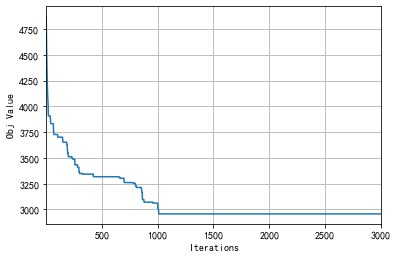

whole time: 112.11942410469055


In [6]:
start_time = time.time()
file='C:/Users/lisuc/Desktop/Algorithms_for_solving_VRP-master/data/c101.xlsx'
run(file,3000,80,1)
end_time = time.time()
print("whole time:",end_time - start_time)